In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def integrate(T,dt, Xc, stimtime, secpulsetime, secpulse, k1,k2,km1,km2):
    numsteps = int((T+1)/dt)
    times = np.linspace(-1,T,numsteps)
    R = np.zeros(numsteps)
    R[0]= R0
    B = np.zeros(numsteps)
    A = np.zeros(numsteps)

    C = np.zeros(numsteps)
    CNG = np.zeros(numsteps)

    Ca = np.zeros(numsteps)
    Ca[0] = 0.1
    CaCaM = np.zeros(numsteps)
    CaCaM[0] = (KCaM*0.1**4*CaM0)/(KCaM*0.1**4+delCaM)
    
    X = Xc*np.zeros(numsteps)
    for i in range(numsteps):
        if times[i] < 0:
            continue
        if times[i] < stimtime:
            X[i] = Xc
        elif secpulse == 1 and times[i] > stimtime + secpulsetime and times[i] < stimtime + secpulsetime + stimtime:
            X[i] = Xc

    for i in range(1,numsteps):
        R[i] = R[i-1] + dt*(km1*B[i-1] - k1*R[i-1]*X[i-1])
        B[i] = B[i-1] + dt*(k1*R[i-1]*X[i-1] + km2*A[i-1] - km1*B[i-1] - k2*B[i-1])
        A[i] = A[i-1] + dt*(k2*B[i-1] - km2*A[i-1])

        C[i] = C[i-1] + dt*(KC*A[i-1] - delC*C[i-1])

        CNG[i] = (C[i-1]**n)/(C[i-1]**n + ((1.0 + (CaCaM[i-1]/CaCaM0)**nini)/kG)**n)
        Ca[i] = Ca[i-1] + dt*(KCa*CNG[i-1] - delCa1*(Ca[i-1]-Ca01) - delCa2*(Ca[i-1]-Ca02) - 4*KCaM*Ca[i-1]**4*(CaM0-CaCaM[i-1]) + 4*delCaM*CaCaM[i-1])
        CaCaM[i] = CaCaM[i-1] + dt*(KCaM*Ca[i-1]**4*(CaM0-CaCaM[i-1]) - delCaM*CaCaM[i-1])
    return C, Ca , CaCaM , CNG

## Equations:


Receptor Binding:
$$ R + X_i \underset{km_1}{\stackrel{k_1}{\rightleftharpoons}} RX_i \underset{km_2}{\stackrel{k_2}{\rightleftharpoons}} RX_i^* $$

cAMP Production:
$$RX_i^* \stackrel{k_C}{\rightarrow} cAMP \stackrel{\delta_C}{\rightarrow} \varnothing $$

CNG Channel activation (Hill-like Allosteric activation modulated by CaCaM):
$$CNG = \frac{cAMP^n}{cAMP^n+\Bigg(\frac{1+\big(\frac{CaCaM}{CaCaM_0}\big)^{nini}}{k_G}\Bigg)^n}$$

Ca Flux:
$$CNG \stackrel{k_{Ca}}{\rightleftharpoons} Ca $$

In [10]:
k1 = 1/(0.010)                                 # rate of R+X binding
km1 = 1/(0.010)                                # rate of R+X debinding   
k2 = 1/(0.5)                                   # rate of RX activation
km2 = 1/(0.5)                                  # rate of RX deactivation

KC = 1/(0.5)                                   # rate of production of cAMP
delC = 1/(1)                                   # rate of degradation of cAMP

kG = 10                                        # overall rate of cAMP-CNG binding

KCa = 2 ## Choose to find height                                   # overall rate of Ca influx    
delCa1 = 1 ## Need to find                                  # rate of Ca decay in cytosol
delCa2 = 10 ## Need to find                                  # rate of Ca decay in cytosol

KCaM = 6.8                                     # Rate limited binding # rate of CaM binding
delCaM = 0.33                                  # rate of CaM debinding

R0 = 1                                         # total receptors at beginning
n = 4                                          # number of allosteric binding site
CaM0 = 5                                    # initial CaM concentration https://www.nature.com/articles/nn1266?platform=oscar&draft=collection
CaCaM0 = (KCaM*0.1**4*CaM0)/(KCaM*0.1**4+delCaM) # baseline CaM concentration https://www.nature.com/articles/nn1266?platform=oscar&draft=collection
nini = 2                                       # hill coefficient

Ca01 = 0.15 #uM
if delCa2 >0:
    Ca02 = 0.1+delCa1/delCa2*(0.1-Ca01) #uM
else:
    Ca02 = 0

In [11]:
CaCaM0/CaM0

0.0020563686948106936

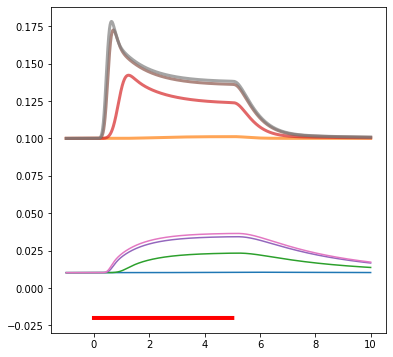

In [14]:
%matplotlib inline
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 4
Xconcs = np.logspace(-1.5,1.5,num)

dt = 0.0001
T = 10
stimtime = 5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs = np.zeros((num, numsteps))
Cas = np.zeros((num, numsteps))
CaMs = np.zeros((num, numsteps))
CNGs = np.zeros((num, numsteps))

for i in range(len(Xconcs)):
    Cs[i],Cas[i],CaMs[i],CNGs[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2)
    axis.plot(times, CaMs[i], '-')
#     axis.plot(times, CNGs[i], '-')
    axis.plot(times, Cas[i], '-', lw = 3, alpha = 0.7)
stim = times[(times < stimtime)*(times > 0)]
axis.plot(stim , -0.02*np.ones(len(stim)), 'r-', lw = 4, alpha = 1)

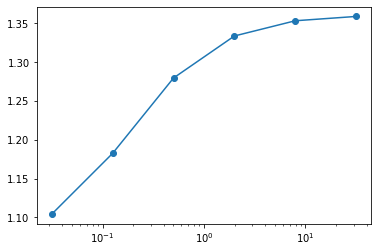

In [33]:
plt.plot(Xconcs,Cas.sum(axis=1)*dt,'o-')
plt.xscale('log')

In [34]:
def conc_profile():
    dt = 0.0001
    T = 5
    stimtime = 0.5
    secpulsetime = 8
    secpulse = 0
    numsteps = int((T+1)/dt)
    times = np.linspace(-1,T,numsteps)
    Cs = np.zeros((num, numsteps))
    Cas = np.zeros((num, numsteps))
    for i in range(len(Xconcs)):
        Cs[i],Cas[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2)
    return Cas.sum(axis=1)*dt

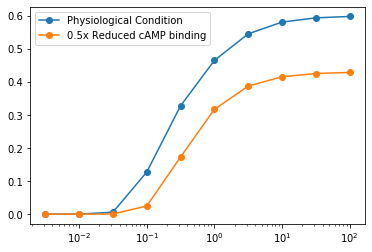

In [38]:
num = 10
Xconcs = np.logspace(-2.5,2,num)
### Paramset 1
kG = 10                                        # overall rate of cAMP-CNG binding
plt.plot(Xconcs,conc_profile(),'o-',label = 'Physiological Condition')
### Paramset 2
kG = 5                                         # overall rate of cAMP-CNG binding
plt.plot(Xconcs,conc_profile(),'o-',label = '0.5x Reduced cAMP binding')
plt.xscale('log')
plt.legend()

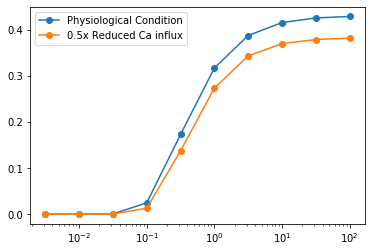

In [42]:
num = 10
Xconcs = np.logspace(-2.5,2,num)
### Paramset 1
KCa = 1/(0.050)                                # overall rate of Ca influx    
plt.plot(Xconcs,conc_profile(),'o-',label = 'Physiological Condition')
### Paramset 2
KCa = 1/(0.050)*0.5                            # overall rate of Ca influx    
plt.plot(Xconcs,conc_profile(),'o-',label = '0.5x Reduced Ca influx')
plt.xscale('log')
plt.legend()

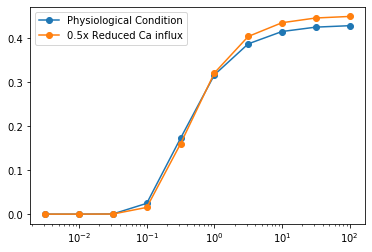

In [44]:
num = 10
Xconcs = np.logspace(-2.5,2,num)
### Paramset 1
KCa = 1/(0.050)                                # overall rate of Ca influx  
delCa = 1/(2)                                  # rate of Ca decay in cytosol
plt.plot(Xconcs,conc_profile(),'o-',label = 'Physiological Condition')
### Paramset 2
KCa = 1/(0.050)*0.5                            # overall rate of Ca influx    
delCa = 1/(2)*0.5                                  # rate of Ca decay in cytosol
plt.plot(Xconcs,conc_profile(),'o-',label = '0.5x Reduced Ca influx')
plt.xscale('log')
plt.legend()

In [372]:
#### OR pathway parameters ####

k1 = 1/(0.010)                                 # rate of R+X binding
km1 = 1/(0.010)                                # rate of R+X debinding   
k2 = 1/(0.5)                                   # rate of RX activation
km2 = 1/(0.5)                                  # rate of RX deactivation

KC = 1/(0.5)                                   # rate of production of cAMP
delC = 1/(1)                                   # rate of degradation of cAMP

kG = 10                                        # overall rate of cAMP-CNG binding

KCa = 1/(0.050)                                # overall rate of Ca influx    
delCa = 1/(2)                                  # rate of Ca decay in cytosol

KCaM = 1/(1)                                   # rate of CaM binding
delCaM = 1/(3)                                 # rate fo CaM debinding

R0 = 1                                         # total receptors at beginning
nhill = 4                                      # number of allosteric binding site
CaM0 = 0.05                                    # initial CaM concentration
nini = 2                                       # hill coefficient

# Amazing Calcium details https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2229177

Ca0 = 0.05 # uM Ref: Resting Calcium conc www.ncbi.nlm.nih.gov/pmc/articles/PMC2442823/

#### Neuron Parameters ####
Cm = 1 # uF/cm2
VT = -52 # mV

# Sodium current #

gNa = 50 # mS/cm2
ENa = 50 # mV

def Na_kinetics(V):
    am = (-0.32*(V-VT-13))/(np.exp(-(V-VT-13)/4)-1)
    bm = (0.28*(V-VT-40))/(np.exp((V-VT-40)/5)-1)
    ah = 0.128*np.exp(-(V-VT-17)/18)
    bh = 4/(1+np.exp(-(V-VT-40)/5))
    return am,bm,ah,bh

# Potassium Delayed Rectifier current #

gKd = 5 #uS/cm2
EKd = -90 #mV

def Kd_kinetics(V):
    an = (-0.032*(V-VT-15))/(np.exp(-(V-VT-15)/5)-1)
    bn = 0.5*np.exp(-(V-VT-10)/40)
    return an,bn

# Leak Current #
gL = 0.01 # uS/cm2
EL = -60 # mV

# CNG Current # https://doi.org/10.1085/jgp.100.1.45
gCNG = 0.01 # uS/cm2
ECNG = -10 # mV

# KCa Current #
gKCa = 0.1 # uS/cm2
EKCa = EKd # mV

def KCa_kinetics(Ca):
    return Ca/(Ca+2),100/(Ca+2)

# Ca-Cl Current # https://doi.org/10.1152/ajpgi.00449.2013

gCl = 0.5 #uS/cm2
ECl = -40 #mV

CaEC50_0 = 0.2 # Calcium half-activation concentration
Ca_rescale = 1.39/CaEC50_0 
ClVh = -100 #mV  # Ca-Cl half activation voltage
Clkv = 0.0156 # mV-1 #Ca-Cl slope factor
Cakc = 0.01248 # mV−1 

def CaCl_kinetics(V,Ca_):
    Ca = Ca_*Ca_rescale
    CaEC50 = CaEC50_0*np.exp(-Cakc*V)
    cinf = 1/((1+np.exp(ClVh-V)*Clkv)*(1+(CaEC50/Ca_)**2))
    t1=0.08163*np.exp(-0.57*Ca)
    t2=0.07617*np.exp(-0.05374*Ca)
    t3=70.3*np.exp(0.153*Ca)
    tau = t1+t2*np.exp(V/t3)
    return cinf,tau

In [373]:
def integrate_neuron(T,dt, X, k1, k2, km1, km2):
    numsteps = int((T+1)/dt)
    times = np.linspace(-1,T,numsteps)
    
    R = np.zeros(numsteps)
    R[0]= R0
    B = np.zeros(numsteps)
    A = np.zeros(numsteps)
    C = np.zeros(numsteps)
    CNG = np.zeros(numsteps)
    Ca = np.zeros(numsteps)
    CaM = np.zeros(numsteps)
    
    V = np.zeros(numsteps)
    V[0] = EL
    
    m = np.zeros(numsteps)
    h = np.zeros(numsteps)
    n = np.zeros(numsteps)
    c = np.zeros(numsteps)
    d = np.zeros(numsteps)

    for i in range(1,numsteps):
        # OR integration
        R[i] = R[i-1] + dt*(km1*B[i-1] - k1*R[i-1]*X[i-1])
        B[i] = B[i-1] + dt*(k1*R[i-1]*X[i-1] + km2*A[i-1] - km1*B[i-1] - k2*B[i-1])
        A[i] = A[i-1] + dt*(k2*B[i-1] - km2*A[i-1])
        C[i] = C[i-1] + dt*(KC*A[i-1] - delC*C[i-1])
        CNG[i] = (C[i-1]**nhill)/(C[i-1]**nhill + ((1.0 + (CaM[i-1]/CaM0)**nini)/kG)**nhill)
        Ca[i] = Ca[i-1] + dt*(KCa*CNG[i-1] - delCa*Ca[i-1] - KCaM*Ca[i-1])
        CaM[i] = CaM[i-1] + dt*(KCaM*Ca[i-1] - delCaM*CaM[i-1])
        # Neuron Integration
        INa = gNa*m[i-1]**3*h[i-1]*(V[i-1]-ENa)
        IKd = gKd*n[i-1]**4*(V[i-1]-EKd)
        ICNG = gCNG*CNG[i-1]*(V[i-1]-ECNG)
        ICl = gCl*c[i-1]*(V[i-1]-ECl)
        IKCa = gKCa*d[i-1]*(V[i-1]-EKCa)
        
        V[i] = V[i-1] + 1000*dt*1/Cm*(-gL*(V[i-1]-EL)-INa-IKd-ICNG-ICl-IKCa)
        
        am,bm,ah,bh = Na_kinetics(V[i-1])
        an,bn = Kd_kinetics(V[i-1])
        cinf,tauc = CaCl_kinetics(V[i-1],Ca[i-1])
        dinf,taud = KCa_kinetics(Ca[i-1])
        
        m[i] = m[i-1] + 1000*dt*(am*(1-m[i-1])-bm*m[i-1])
        h[i] = h[i-1] + 1000*dt*(ah*(1-h[i-1])-bh*h[i-1])
        n[i] = n[i-1] + 1000*dt*(an*(1-n[i-1])-bn*n[i-1])
        c[i] = c[i-1] + 1000*dt*(-1/tauc*(c[i-1]-cinf))
        d[i] = d[i-1] + 1000*dt*(-1/taud*(d[i-1]-dinf))
    return V, Ca, d #, CaM , CNG

In [421]:
dt = 0.00002
T = 5
numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

stimtime = 0.5
secpulsetime = 8
secpulse = 0

Vss = []
for Xc in np.logspace(-1,2,4):
    print(Xc)
    X = np.zeros(numsteps)
    for i in range(numsteps):
        if times[i] < 0:
            continue
        if times[i] < stimtime:
            X[i] = Xc
        elif secpulse == 1 and times[i] > stimtime + secpulsetime and times[i] < stimtime + secpulsetime + stimtime:
            X[i] = Xc
    Vs,Cas,ds = integrate_neuron(T,dt,X,k1,k2,km1,km2)
    Vss.append(Vs)

0.1


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars


1.0
10.0
100.0


In [422]:
%matplotlib widget
# plt.fi
i=0
for Vs in Vss[:-1]:
    plt.plot(time,120*i+Vs,alpha=0.5,label=np.logspace(-1,1,3)[i])
    i+=1
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
%matplotlib widget
plt.plot(times,X)

In [423]:
%matplotlib widget
plt.plot(np.linspace(-1,T,numsteps),Cas)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [365]:
%matplotlib widget
for Vs in Vss:
    ind = time[:-1][np.logical_and(Vs[1:]>0,Vs[:-1]<0)]
    plt.plot(ind[:-1],1/np.diff(ind))
    plt.xlim(time[0],time[-1])
    print(len(ind)/(ind[-1]-ind[0]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

14.922848615486648
53.99550035997121
61.81092517166144
62.37600423558059


In [346]:
len(ind)/(ind[-1]-ind[0])

58.599461891319685

In [402]:
%matplotlib widget
plt.plot(np.convolve(np.random.normal(size=numsteps),1/50*np.ones(5000),mode='same'))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

49999